In [1]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset import QuickDrawDataset
from utils import svg_strokes_to_tensor_quantized, tensor_to_svg_strokes
from torchvision.utils import make_grid
from tqdm import tqdm
from itertools import cycle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [3]:
labels = ["cat", "dog", "airplane"]

def to_tensor_quantized_64(svg_content):
    return svg_strokes_to_tensor_quantized(svg_content, bins=64).to(dtype=torch.int8)

training_data = QuickDrawDataset(
    labels=labels,
    base_transform=to_tensor_quantized_64,
    cache_file="data/quickdraw_all_quantized_64bins.pt",
)

Loading QuickDraw files: 100%|██████████| 3/3 [00:10<00:00,  3.53s/it]


In [4]:
print(training_data[0])

tensor([[ 32,  18,   0],
        [ -4,  -8,   1],
        [ -4,  -3,   1],
        [  3,  12,   1],
        [ -8,   1,   1],
        [ -3,   2,   1],
        [ -2,   3,   1],
        [ -2,   5,   1],
        [  0,   3,   1],
        [  1,   4,   1],
        [  2,   4,   1],
        [  6,   4,   1],
        [ 12,   2,   1],
        [  5,  -1,   1],
        [  4,  -2,   1],
        [  8,  -7,   1],
        [  3,  -5,   1],
        [  0,  -4,   1],
        [  0,  -3,   1],
        [ -2,  -3,   1],
        [ -5,  -3,   1],
        [ -3, -19,   1],
        [ -3,   8,   1],
        [ -1,   8,   1],
        [ -7,   1,   1],
        [-13,  16,   0],
        [-12,  -1,   1],
        [ -5,   0,   1],
        [ 17,   7,   0],
        [-13,   1,   1],
        [ -6,   3,   1],
        [ 21,   0,   0],
        [ -8,   4,   1],
        [ -4,   3,   1],
        [ 34, -17,   0],
        [ 11,  -1,   1],
        [  7,   1,   1],
        [  1,   1,   1],
        [-19,   2,   0],
        [ 20,   5,   1],


In [5]:
print(training_data[0].shape) # torch.Size([200, 3])
print(len(training_data))
loader = DataLoader(training_data, batch_size=32, shuffle=False, pin_memory=True)
# loader = cycle(loader)

def normalize_strokes(batch, scale=128.0):
    batch = batch.clone().float()
    # Normalize delta x, delta y
    batch[..., 0:2] = batch[..., 0:2] / scale
    # Leave pen_state as is (0, 1)
    return batch

torch.Size([200, 3])
382139


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import pickle

def save_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    

data0 = [] # points with penstate=0
data1 = [] # points with penstate=1

for batch in tqdm(loader):
    batch = batch.to(device)
    batch = normalize_strokes(batch, scale=64.0)
    batch = batch.view(-1, 3).cpu().numpy()
    # Exclude rows where dx, dy, and penstate are all zero
    mask_nonzero = ~np.all(batch == 0, axis=1)
    batch = batch[mask_nonzero]
    # Separate by penstate
    mask0 = batch[:, 2] == 0
    mask1 = batch[:, 2] == 1
    data0.append(batch[mask0][:, :2])
    data1.append(batch[mask1][:, :2])


data0 = np.concatenate(data0, axis=0)
data1 = np.concatenate(data1, axis=0)
N_P0, N_P1 = data0.shape[0], data1.shape[0]

p1_ratio = 0.2

n_p1 = int(p1_ratio * len(training_data))
n_p0 = len(training_data) - n_p1
if N_P0 > n_p0:
    print("Sample %d out of %d points with penstate 0" % (n_p0, N_P0))
    ids_p0 = np.random.choice(N_P0, n_p0, replace=False)
    data_p0 = data0[ids_p0]
if N_P1 > n_p1:
    print("Sample %d out of %d points with penstate 1" % (n_p1, N_P1))
    ids_p1 = np.random.choice(N_P1, n_p1, replace=False)
    data_p1 = data1[ids_p1]
data = np.r_[data_p0, data_p1]


vocab_size = 1000
cluster = KMeans(n_clusters=vocab_size, n_init=10, max_iter=500, tol=1e-6).fit(data)

save_pickle("data/quickdraw_all_quantized_64bins_kmeans4096.pkl", cluster)

100%|██████████| 11942/11942 [00:05<00:00, 2143.04it/s]


Sample 305712 out of 2506295 points with penstate 0
Sample 76427 out of 17054147 points with penstate 1


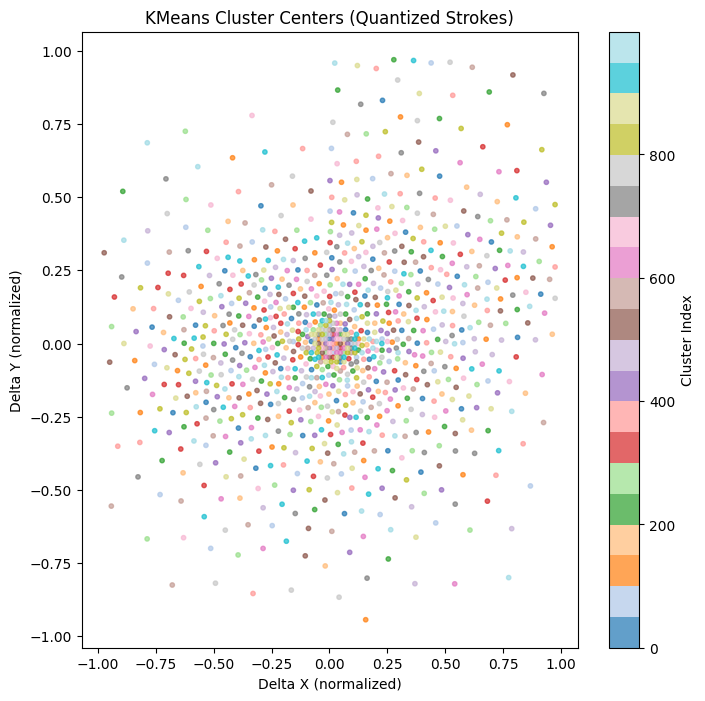

In [7]:
# Visualize clusters from KMeans
import matplotlib.pyplot as plt

data = cluster.cluster_centers_
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=10, c=range(len(data)), cmap='tab20', alpha=0.7)
plt.title("KMeans Cluster Centers (Quantized Strokes)")
plt.xlabel("Delta X (normalized)")
plt.ylabel("Delta Y (normalized)")
plt.colorbar(label="Cluster Index")
plt.show()